In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import tiktoken as tk
import numpy as np

In [1]:
import urllib.request
import zipfile
import os
from pathlib import Path

## **Utility functions**

In [3]:
tokenizer = tk.get_encoding("gpt2")

In [4]:
def text_to_token_ids(text, tokenizer):
  encoded = tokenizer.encode(text)
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor

def token_ids_to_text(tokens, tokenizer):
  token_list = tokens.squeeze(0).tolist()
  decoded = tokenizer.decode(token_list)
  return decoded

## **Dataset Preparation**

In [5]:
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "/content/drive/My Drive/LLM/Data/sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
  if data_file_path.exists():
    print(f'{data_file_path} already exists. Skipping download and extraction.')
    return

  with urllib.request.urlopen(url) as response:
    with open(zip_path, "wb") as out_file:
      out_file.write(response.read())

  with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extracted_path)

  original_file_path = Path(extracted_path) / "SMSSpamCollection"
  os.rename(original_file_path, data_file_path)
  print(f'File downloaded and saved as {data_file_path}')

In [6]:
download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

/content/drive/My Drive/LLM/Data/sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [7]:
import pandas as pd

data = pd.read_csv(data_file_path, sep='\t', header=None, names=['Label', 'Text'])
data.head()

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
def balance_dataset(df):
  labels = df['Label'].unique()
  label_counts = [df[df['Label']==label]['Label'].count() for label in labels]
  num_sam = min(label_counts)
  min_class = labels[label_counts.index(num_sam)]
  undersampled_data = df[df['Label']!=min_class].sample(num_sam, random_state=123)

  balanced_df = pd.concat([undersampled_data, df[df['Label']==min_class]], axis=0)

  return balanced_df

In [9]:
balance_df = balance_dataset(data)
balance_df['Label'] = balance_df['Label'].map({'ham':0, 'spam':1})
balance_df['Label'].value_counts()

,count
Label,
0,747
1,747


In [10]:
def split_dataset(df, train_ratio, val_ratio):
  df = df.sample(frac=1, random_state=123).reset_index(drop=True)
  length = len(df)
  train_len = int(length * train_ratio)
  val_len = int(length * val_ratio)

  train_df = df[:train_len]
  val_df = df[train_len : train_len + val_len]
  test_df = df[train_len + val_len:]

  return train_df, val_df, test_df

In [11]:
train_df, val_df, test_df = split_dataset(balance_df, 0.7, 0.1)
train_df.to_csv("/content/drive/My Drive/LLM/Data/sms_spam_collection/train.csv", index=None)
val_df.to_csv("/content/drive/My Drive/LLM/Data/sms_spam_collection/validation.csv", index=None)
test_df.to_csv("/content/drive/My Drive/LLM/Data/sms_spam_collection/test.csv", index=None)

In [12]:
class SpamDataset(Dataset):
  def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
    self.df = pd.read_csv(csv_file)

    self.encoded = [tokenizer.encode(text) for text in self.df['Text']]

    if max_length is None:
      self.max_length = max([len(token_list) for token_list in self.encoded])
    else:
      self.max_length = max_length

    self.encoded = [token_list[:max_length] for token_list in self.encoded]
    self.encoded = [token_list + [pad_token_id] * (self.max_length - len(token_list)) for token_list in self.encoded]

    self.label = self.df['Label']

  def __getitem__(self, index):
    return torch.tensor(self.encoded[index]), torch.tensor(self.label[index])

  def __len__(self):
    return len(self.df)

In [13]:
train_path = "/content/drive/My Drive/LLM/Data/sms_spam_collection/train.csv"

train_dataset = SpamDataset(train_path, tokenizer)

print("Max input sequence length: ", train_dataset.max_length)
print("Length of dataset: ", len(train_dataset))

Max input sequence length:  120
Length of dataset:  1045


In [14]:
val_path = "/content/drive/My Drive/LLM/Data/sms_spam_collection/validation.csv"
test_path = "/content/drive/My Drive/LLM/Data/sms_spam_collection/test.csv"

val_dataset = SpamDataset(val_path, tokenizer, max_length=train_dataset.max_length)
test_dataset = SpamDataset(test_path, tokenizer, max_length=train_dataset.max_length)

In [15]:
num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=False)

## **Initialize model with pretrained weights**

In [16]:
class MultiHeadAttention(nn.Module):
  def __init__(self, dim_in, dim_out, context_length, dropout, num_heads, qkv_bias=False):
    super().__init__()
    assert (dim_out % num_heads == 0), "dim_out must be divisible by num_heads"

    self.dim_out = dim_out # final merged context vector embedding size
    self.num_heads = num_heads
    self.head_dim = dim_out//num_heads # embedding size of context vector in single head
    self.w_query = torch.nn.Linear(dim_in, dim_out, bias=qkv_bias)
    self.w_key = torch.nn.Linear(dim_in, dim_out, bias=qkv_bias)
    self.w_value = torch.nn.Linear(dim_in, dim_out, bias=qkv_bias)
    self.out_proj = torch.nn.Linear(dim_out, dim_out) # transform merged context_vectors into similar dimension size vectors
    self.dropout = torch.nn.Dropout(dropout)
    self.register_buffer(
        'mask',
        torch.triu(torch.ones(context_length, context_length), diagonal=1)
    )

  def forward(self, x):
    batch_size, num_tokens, dim_in = x.shape
    queries = self.w_query(x)
    keys = self.w_key(x)
    values = self.w_value(x)  #shape (batch_size, num_tokens, dim_out)

    queries = queries.view(batch_size, num_tokens, self.num_heads, self.head_dim)
    keys = keys.view(batch_size, num_tokens, self.num_heads, self.head_dim)
    values = values.view(batch_size, num_tokens, self.num_heads, self.head_dim) #shape (batch_size, num_tokens, num_heads, head_dim)

    queries = queries.transpose(1,2)
    keys = keys.transpose(1,2)
    values = values.transpose(1,2) #shape (batch_size, num_heads, num_tokens, head_dim)

    attention_scores = queries @ keys.transpose(2,3)
    attention_scores.masked_fill_(self.mask.bool()[:num_tokens,:num_tokens], -torch.inf)

    attention_weights = torch.softmax(attention_scores/keys.shape[-1]**0.5, dim=-1)
    attention_weights = self.dropout(attention_weights)

    context_vectors = (attention_weights @ values).transpose(1,2) #transposing axis 1,2  since we have to merge the context vectors by num_heads and head_dim, so required shape will now be (batch_size, num_tokens, num_heads, head_dim)
    context_vectors = context_vectors.contiguous().view(batch_size, num_tokens, self.dim_out)

    context_vectors = self.out_proj(context_vectors)

    return context_vectors

In [17]:
class LayerNorm(nn.Module):
  def __init__(self, emb_size):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_size))
    self.shift = nn.Parameter(torch.zeros(emb_size))

  def forward(self, x):
    mean = x.mean(keepdim=True, dim=-1)
    variance = x.var(keepdim=True, dim=-1, unbiased=False)
    norm_x = (x - mean)/torch.sqrt(variance + self.eps)
    return self.scale * norm_x + self.shift

In [18]:
class GeLU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x,3))
    ))

In [19]:
class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg['emb_size'], 4 * cfg['emb_size']),
        GeLU(),
        nn.Linear(4 * cfg['emb_size'], cfg['emb_size'])
    )

  def forward(self, x):
    return self.layers(x)

In [20]:
class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.mha = MultiHeadAttention(cfg['emb_size'], cfg['emb_size'], cfg['context_length'], cfg['drop_rate'], cfg['num_heads'], qkv_bias=cfg['qkv_bias'])
    self.layer_norm1 = LayerNorm(cfg['emb_size'])
    self.layer_norm2 = LayerNorm(cfg['emb_size'])
    self.ffn = FeedForward(cfg)
    self.dropout = nn.Dropout(cfg['drop_rate'])

  def forward(self, x):
    shortcut = x
    x = self.layer_norm1(x)
    x = self.mha(x)
    x = self.dropout(x)
    x = x + shortcut

    shortcut = x
    x = self.layer_norm2(x)
    x = self.ffn(x)
    x = self.dropout(x)
    x = x + shortcut

    return x

In [21]:
class GPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.token_emb_layer = nn.Embedding(cfg['vocab_size'], cfg['emb_size'])
    self.pos_emb_layer = nn.Embedding(cfg['context_length'], cfg['emb_size'])
    self.dropout_layer = nn.Dropout(cfg['drop_rate'])
    self.trf_blocks = nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg['num_layers'])]
    )
    self.final_norm = LayerNorm(cfg['emb_size'])
    self.output_layer = nn.Linear(cfg['emb_size'], cfg['vocab_size'], bias=False)

  def forward(self, inp_tokens):
    batch_size, num_tokens = inp_tokens.shape
    token_emb = self.token_emb_layer(inp_tokens)
    pos_emb = self.pos_emb_layer(
        torch.arange(num_tokens, device=inp_tokens.device)
    )
    x = token_emb + pos_emb
    x = self.dropout_layer(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.output_layer(x)

    return logits

In [22]:
import sys
sys.path.append('/content/drive/My Drive/LLM/Notebooks')

In [49]:
BASE_CONFIG = {
    'vocab_size': 50257,
    'context_length': 1024,
    'drop_rate': 0.0,
    'qkv_bias': True
}

model_configs = {
    'gpt2-small (124M)': {
        'emb_size':768,
        'num_heads':12,
        'num_layers':12,
    },
    'gpt2-medium (355M)': {
        'emb_size':1024,
        'num_heads':16,
        'num_layers':24,
    },
    'gpt2-large (774M)': {
        'emb_size':1280,
        'num_heads':20,
        'num_layers':36,
    },
    'gpt2-xl (1558M)': {
        'emb_size':1600,
        'num_heads':25,
        'num_layers':48,
    }
}

In [50]:
model_name = 'gpt2-small (124M)'
model_size = model_name.split(' ')[-1].lstrip('(').rstrip(')')
BASE_CONFIG.update(model_configs[model_name])

In [51]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(model_size=model_size, models_dir='gpt2')

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [52]:
def assign(left, right):
  if left.shape != right.shape:
    raise ValueError(f'Shape mismatch. Left: {left.shape}. Right: {right.shape}')
  return torch.nn.Parameter(torch.tensor(right))

In [53]:
def load_parameters(gpt, params):
  gpt.token_emb_layer.weight = assign(gpt.token_emb_layer.weight, params['wte'])
  gpt.pos_emb_layer.weight = assign(gpt.pos_emb_layer.weight, params['wpe'])

  #transformer blocks' parameters loading
  for b in range(len(params['blocks'])):
    #each blocks' mha qkv weights
    q_w, k_w, v_w = np.split(
        params['blocks'][b]['attn']['c_attn']['w'], 3, axis=-1
    )
    gpt.trf_blocks[b].mha.w_query.weight = assign(
        gpt.trf_blocks[b].mha.w_query.weight, q_w.T
    )
    gpt.trf_blocks[b].mha.w_key.weight = assign(
        gpt.trf_blocks[b].mha.w_key.weight, k_w.T
    )
    gpt.trf_blocks[b].mha.w_value.weight = assign(
        gpt.trf_blocks[b].mha.w_value.weight, v_w.T
    )

    #each blocks' mha qkv bias
    q_b, k_b, v_b = np.split(
        params['blocks'][b]['attn']['c_attn']['b'], 3, axis=-1
    )
    gpt.trf_blocks[b].mha.w_query.bias = assign(
        gpt.trf_blocks[b].mha.w_query.bias, q_b
    )
    gpt.trf_blocks[b].mha.w_key.bias = assign(
        gpt.trf_blocks[b].mha.w_key.bias, k_b
    )
    gpt.trf_blocks[b].mha.w_value.bias = assign(
        gpt.trf_blocks[b].mha.w_value.bias, v_b
    )

    #each blocks' mha out_proj layer's weight and bias
    gpt.trf_blocks[b].mha.out_proj.weight = assign(
        gpt.trf_blocks[b].mha.out_proj.weight, params['blocks'][b]['attn']['c_proj']['w'].T
    )
    gpt.trf_blocks[b].mha.out_proj.bias = assign(
        gpt.trf_blocks[b].mha.out_proj.bias, params['blocks'][b]['attn']['c_proj']['b']
    )

    #each blocks' ff wieghts and biases
    gpt.trf_blocks[b].ffn.layers[0].weight = assign(
        gpt.trf_blocks[b].ffn.layers[0].weight, params['blocks'][b]['mlp']['c_fc']['w'].T
    )
    gpt.trf_blocks[b].ffn.layers[0].bias = assign(
        gpt.trf_blocks[b].ffn.layers[0].bias, params['blocks'][b]['mlp']['c_fc']['b']
    )
    gpt.trf_blocks[b].ffn.layers[2].weight = assign(
        gpt.trf_blocks[b].ffn.layers[2].weight, params['blocks'][b]['mlp']['c_proj']['w'].T
    )
    gpt.trf_blocks[b].ffn.layers[2].bias = assign(
        gpt.trf_blocks[b].ffn.layers[2].bias, params['blocks'][b]['mlp']['c_proj']['b']
    )

    #each blocks' layer_norms scale and shift
    gpt.trf_blocks[b].layer_norm1.scale = assign(
        gpt.trf_blocks[b].layer_norm1.scale, params['blocks'][b]['ln_1']['g']
    )
    gpt.trf_blocks[b].layer_norm1.shift = assign(
        gpt.trf_blocks[b].layer_norm1.shift, params['blocks'][b]['ln_1']['b']
    )
    gpt.trf_blocks[b].layer_norm2.scale = assign(
        gpt.trf_blocks[b].layer_norm2.scale, params['blocks'][b]['ln_2']['g']
    )
    gpt.trf_blocks[b].layer_norm2.shift = assign(
        gpt.trf_blocks[b].layer_norm2.shift, params['blocks'][b]['ln_2']['b']
    )

  #gpt's final_layer_norm
  gpt.final_norm.scale = assign(
        gpt.final_norm.scale, params['g']
  )
  gpt.final_norm.shift = assign(
        gpt.final_norm.shift, params['b']
  )
  gpt.output_layer.weight = assign(
      gpt.output_layer.weight, params['wte']
  )

In [54]:
gpt = GPTModel(BASE_CONFIG)

In [55]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

In [56]:
load_parameters(gpt, params)
gpt.eval()

GPTModel(
  (token_emb_layer): Embedding(50257, 768)
  (pos_emb_layer): Embedding(1024, 768)
  (dropout_layer): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (mha): MultiHeadAttention(
        (w_query): Linear(in_features=768, out_features=768, bias=True)
        (w_key): Linear(in_features=768, out_features=768, bias=True)
        (w_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (layer_norm1): LayerNorm()
      (layer_norm2): LayerNorm()
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GeLU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (mha): MultiHeadAttention(
        (w_qu

In [57]:
#freeze the weights of whole model so that it can't be updated
for params in gpt.parameters():
  params.requires_grad = False

In [58]:
#Replace the output_layer having 50257 nodes with output_layer having 2 nodes for 2 classes
torch.manual_seed(123)
num_classes = 2
gpt.output_layer = nn.Linear(BASE_CONFIG['emb_size'], num_classes)

In [59]:
#Lets unfreeze the weights of last transformer block and final_norm layer for classification fine-tuning
for params in gpt.trf_blocks[-1].parameters():
  params.requires_grad = True
for params in gpt.final_norm.parameters():
  params.requires_grad = True

In [ ]:
#Lets have a look at model structure to confirm that architectural changes has been made
print(gpt)

GPTModel(
  (token_emb_layer): Embedding(50257, 768)
  (pos_emb_layer): Embedding(1024, 768)
  (dropout_layer): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (mha): MultiHeadAttention(
        (w_query): Linear(in_features=768, out_features=768, bias=True)
        (w_key): Linear(in_features=768, out_features=768, bias=True)
        (w_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (layer_norm1): LayerNorm()
      (layer_norm2): LayerNorm()
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GeLU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (mha): MultiHeadAttention(
        (w_qu

In [60]:
#Lets try one example text
text = "You have won the lottery"
encoded_text = text_to_token_ids(text, tokenizer)

output = gpt(encoded_text)
print(output.shape)
print(output)

torch.Size([1, 5, 2])
tensor([[[-1.8217,  1.4904],
         [-2.5725,  5.7342],
         [-2.4992,  4.3028],
         [-2.6321,  5.0198],
         [-3.3008,  4.8718]]], grad_fn=<ViewBackward0>)


In [61]:
gpt.to(device)

GPTModel(
  (token_emb_layer): Embedding(50257, 768)
  (pos_emb_layer): Embedding(1024, 768)
  (dropout_layer): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (mha): MultiHeadAttention(
        (w_query): Linear(in_features=768, out_features=768, bias=True)
        (w_key): Linear(in_features=768, out_features=768, bias=True)
        (w_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (layer_norm1): LayerNorm()
      (layer_norm2): LayerNorm()
      (ffn): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GeLU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (mha): MultiHeadAttention(
        (w_qu

In [62]:
#lets define a function for calculating accuracy
def calc_loader_accuracy(dataloader, model, device, num_batches=None):
  model.eval()
  correct_pred = 0
  num_examples = 0
  if num_batches is None:
    num_batches = len(dataloader)
  else:
    num_batches = min(max(0, num_batches), len(dataloader))
  for i, (inp_batch, target_batch) in enumerate(dataloader):
    if i < num_batches:
      num_examples += inp_batch.shape[0]
      inp_batch = inp_batch.to(device)
      target_batch = target_batch.to(device)
      with torch.no_grad():
        logits = model(inp_batch)
      last_token_logits = logits[:,-1,:]
      predictions = torch.argmax(last_token_logits, dim=-1)
      correct_pred += (predictions == target_batch).sum().item()
    else:
      break

  return correct_pred/num_examples

In [63]:
train_accuracy = calc_loader_accuracy(train_loader, gpt, device)
val_accuracy = calc_loader_accuracy(val_loader, gpt, device)
test_accuracy = calc_loader_accuracy(test_loader, gpt, device)

print(f"train accuracy: {train_accuracy}")
print(f"validation accuracy: {val_accuracy}")
print(f"test accuracy: {test_accuracy}")

train accuracy: 0.4951923076923077
validation accuracy: 0.5302013422818792
test accuracy: 0.5033333333333333


In [64]:
#lets define losss function for classification task
def calc_batch_loss(input_batch, target_batch, model, device):
  input_batch = input_batch.to(device)
  target_batch = target_batch.to(device)
  logits = model(input_batch)
  last_token_logits = logits[:,-1,:]
  loss = nn.functional.cross_entropy(last_token_logits, target_batch)
  return loss

In [65]:
def calc_loader_loss(dataloader, model, device, num_batches=None):
  model.eval()
  if len(dataloader)==0:
    return float('nan')
  elif num_batches is None:
    num_batches = len(dataloader)
  elif num_batches <= 0:
    return float('nan')
  else:
    num_batches = min(num_batches, len(dataloader))

  total_loss = 0
  for i, (inp, target) in enumerate(dataloader):
    if i < num_batches:
      loss = calc_batch_loss(inp, target, model, device)
      total_loss += loss.item()
    else:
      break

  return total_loss/num_batches

In [66]:
def evaluate_loss(train_loader, val_loader, model, device, eval_iter):
  model.eval()
  with torch.no_grad():
    train_loss = calc_loader_loss(train_loader, model, device, eval_iter)
    val_loss = calc_loader_loss(val_loader, model, device, eval_iter)
  model.train()
  return train_loss, val_loss

def evaluate_accuracy(train_loader, val_loader, model, device, eval_iter):
  model.eval()
  with torch.no_grad():
    train_acc = calc_loader_accuracy(train_loader, model, device, eval_iter)
    val_acc = calc_loader_accuracy(val_loader, model, device, eval_iter)
  model.train()
  return train_acc, val_acc

In [67]:
#lets define training function
def train_classifier_simple(model, train_loader, val_loader, epochs, optimizer, device, eval_freq, eval_iter):
  train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
  global_step, examples_seen = -1, 0
  model.to(device)

  for epoch in range(epochs):
    model.train()
    for inp, target in train_loader:
      optimizer.zero_grad()
      loss = calc_batch_loss(inp, target, model, device)
      loss.backward()
      optimizer.step()
      global_step += 1
      examples_seen += inp.shape[0]

      if global_step % eval_freq == 0:
        train_loss, val_loss = evaluate_loss(train_loader, val_loader, model, device, eval_freq)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_acc, val_acc = evaluate_accuracy(train_loader, val_loader, model, device, eval_freq)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        print(f"Epoch: {epoch}, Global Step: {global_step}")
        print(f"\t\tTrain Loss: {train_loss}, Val Loss: {val_loss}")
        print(f"\t\tTrain Accuracy: {train_acc}, Val Accuracy: {val_acc}\n\n")

  return train_losses, val_losses, train_accuracies, val_accuracies, examples_seen


In [68]:
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(gpt.parameters(), lr=5e-5, weight_decay=0.1)

train_losses, val_losses, train_accuracies, val_accuracies, examples_seen = train_classifier_simple(gpt, train_loader, val_loader, epochs=5,
                                                                                                    optimizer=optimizer, device=device, eval_freq=50,
                                                                                                    eval_iter=5)
end_time = time.time()
exec_time_mins = (end_time - start_time)/60
print("Training completed in: ", exec_time_mins)

Epoch: 0, Global Step: 0
		Train Loss: 2.323249492645264, Val Loss: 2.2394244859093115
		Train Accuracy: 0.485, Val Accuracy: 0.5302013422818792


Epoch: 0, Global Step: 50
		Train Loss: 0.651064350605011, Val Loss: 0.6399995778736315
		Train Accuracy: 0.765, Val Accuracy: 0.7248322147651006


Epoch: 0, Global Step: 100
		Train Loss: 0.5631248652935028, Val Loss: 0.5556328077065317
		Train Accuracy: 0.82, Val Accuracy: 0.8187919463087249


Epoch: 1, Global Step: 150
		Train Loss: 0.44240942895412444, Val Loss: 0.4633334937848543
		Train Accuracy: 0.84, Val Accuracy: 0.8657718120805369


Epoch: 1, Global Step: 200
		Train Loss: 0.42425449639558793, Val Loss: 0.4084954293150651
		Train Accuracy: 0.84, Val Accuracy: 0.8456375838926175


Epoch: 1, Global Step: 250
		Train Loss: 0.39495714366436, Val Loss: 0.3520399692811464
		Train Accuracy: 0.855, Val Accuracy: 0.8926174496644296


Epoch: 2, Global Step: 300
		Train Loss: 0.3966130502521992, Val Loss: 0.4018028464756514
		Train Accuracy: 

In [69]:
torch.save({
    'model_state_dict': gpt.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, "/content/drive/My Drive/LLM/Data/gpt_and_optimizer.pth")

In [70]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
  fig, ax1 = plt.subplots(figsize=(5, 3))
  ax1.plot(epochs_seen, train_values, label=f"Training {label}")
  ax1.plot(
  epochs_seen, val_values, linestyle="-.",
  label=f"Validation {label}"
  )
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel(label.capitalize())
  ax1.legend()
  ax2 = ax1.twiny()
  ax2.plot(examples_seen, train_values, alpha=0)
  ax2.set_xlabel("Examples seen")
  fig.tight_layout()
  plt.savefig(f"{label}-plot.pdf")
  plt.show()

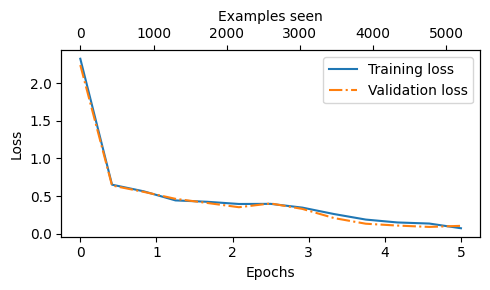

In [72]:
epochs_tensor = torch.linspace(0, 5, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

In [73]:
train_accuracy = calc_loader_accuracy(train_loader, gpt, device)
val_accuracy = calc_loader_accuracy(val_loader, gpt, device)
test_accuracy = calc_loader_accuracy(test_loader, gpt, device)
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 95.87%
Validation accuracy: 95.97%
Test accuracy: 96.67%


In [74]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
  model.eval()
  encoded_text = tokenizer.encode(text)
  if max_length is None:
    max_length = model.pos_emb_layer.weight.shape[0]
  else:
    max_length = min(max_length, model.pos_emb_layer.weight.shape[0])

  encoded_text = encoded_text[: max_length]

  encoded_text += [pad_token_id] * (max_length - len(encoded_text))

  encoded_tensor = torch.tensor(encoded_text, device=device).unsqueeze(0)

  with torch.no_grad():
    logits = gpt(encoded_tensor)
  logits = logits[:, -1, :]
  prediction = torch.argmax(logits, dim=-1).item()
  print(prediction)

  return "spam" if prediction == 1 else "not spam"

In [77]:
text = "You are a winner you have been specially selected to receive $1000 cash or a $2000 award"

output = classify_review(text, gpt, tokenizer, device, max_length=train_dataset.max_length)
print(output)

1
spam
